In [1]:
import pandas as pd
import numpy as np
import wandb
from skimage import filters, transform
from skimage.io import imread
from skimage import img_as_ubyte
from typing import Tuple

# ====================================================
# Library
# ====================================================
import sys
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict


import scipy as sp

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from PIL import ImageFile
# sometimes, you will have images without an ending bit
# this takes care of those kind of (corrupt) images
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.optimizer import Optimizer
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR


import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform


from torch.cuda.amp import autocast, GradScaler

# Functions for plotting:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Train data
train = pd.read_csv('../input/signature-verification-dataset/sign_data/train_data.csv')
train.rename(columns={"1":"label"}, inplace=True)
train["image_real_paths"] = train["068/09_068.png"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/train/{x}")
train["image_forged_paths"] = train["068_forg/03_0113068.PNG"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/train/{x}")

# Test data
test = pd.read_csv('../input/signature-verification-dataset/sign_data/test_data.csv')
test.rename(columns={"1":"label"}, inplace=True)
test["image_real_paths"] = test["068/09_068.png"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/test/{x}")
test["image_forged_paths"] = test["068_forg/03_0113068.PNG"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/test/{x}")

In [3]:
train.shape

(23205, 5)

In [4]:
test.shape

(5747, 5)

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [6]:
class CFG:
    apex=False
    debug=False
    print_freq=100
    size=128
    num_workers=2
    scheduler='OneCycleLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=15
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':4,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':3,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e2,
        'max_lr':1e-3,
        'steps_per_epoch':7, 
        'epochs':7
    }
    batch_size=8
    lr=1e-2
    weight_decay=1e-3
    canvas_size = (952, 1360)
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_size=train["label"].shape[0]
    nfolds=5
    trn_folds=[0]
    model_name='convnet'     #'vit_base_patch32_224_in21k' 'tf_efficientnetv2_b0' 'resnext50_32x4d' 'tresnet_m'
    train=True
    early_stop=True
    target_col="label"
    fc_dim=512
    early_stopping_steps=5
    grad_cam=False
    seed=42
    
if CFG.debug:
    CFG.epochs=1
    train=train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [7]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_key")

import wandb
wandb.login(key=wandb_api)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="Signature", 
                 name="convnet",
                 config=class2dict(CFG),
                 group=CFG.model_name,
                 job_type="train")

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: djoe (use `wandb login --relogin` to force relogin)


In [8]:
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [9]:
def preprocess_signature(img: np.ndarray,
                         canvas_size: Tuple[int, int],
                         img_size: Tuple[int, int] =(170, 242),
                         input_size: Tuple[int, int] =(150, 220)) -> np.ndarray:
    """ Pre-process a signature image, centering it in a canvas, resizing the image and cropping it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The signature image
    canvas_size : tuple (H x W)
        The size of a canvas where the signature will be centered on.
        Should be larger than the signature.
    img_size : tuple (H x W)
        The size that will be used to resize (rescale) the signature
    input_size : tuple (H x W)
        The final size of the signature, obtained by croping the center of image.
        This is necessary in cases where data-augmentation is used, and the input
        to the neural network needs to have a slightly smaller size.
    Returns
    -------
    np.narray (input_size):
        The pre-processed image
    -------
    """
    img = img.astype(np.uint8)
    centered = normalize_image(img, canvas_size)
    inverted = 255 - centered
    resized = resize_image(inverted, img_size)

    if input_size is not None and input_size != img_size:
        cropped = crop_center(resized, input_size)
    else:
        cropped = resized

    return cropped


def normalize_image(img: np.ndarray,
                    canvas_size: Tuple[int, int] = (840, 1360)) -> np.ndarray:
    """ Centers an image in a pre-defined canvas size, and remove
    noise using OTSU's method.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be processed
    canvas_size : tuple (H x W)
        The desired canvas size
    Returns
    -------
    np.ndarray (H x W)
        The normalized image
    """

    # 1) Crop the image before getting the center of mass

    # Apply a gaussian filter on the image to remove small components
    # Note: this is only used to define the limits to crop the image
    blur_radius = 2
    blurred_image = filters.gaussian(img, blur_radius, preserve_range=True)

    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)

    # Find the center of mass
    binarized_image = blurred_image > threshold
    r, c = np.where(binarized_image == 0)
    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())

    # Crop the image with a tight box
    cropped = img[r.min(): r.max(), c.min(): c.max()]

    # 2) Center the image
    img_rows, img_cols = cropped.shape
    max_rows, max_cols = canvas_size

    r_start = max_rows // 2 - r_center
    c_start = max_cols // 2 - c_center

    # Make sure the new image does not go off bounds
    # Emit a warning if the image needs to be cropped, since we don't want this
    # for most cases (may be ok for feature learning, so we don't raise an error)
    if img_rows > max_rows:
        # Case 1: image larger than required (height):  Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        r_start = 0
        difference = img_rows - max_rows
        crop_start = difference // 2
        cropped = cropped[crop_start:crop_start + max_rows, :]
        img_rows = max_rows
    else:
        extra_r = (r_start + img_rows) - max_rows
        # Case 2: centering exactly would require a larger image. relax the centering of the image
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

    if img_cols > max_cols:
        # Case 3: image larger than required (width). Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        c_start = 0
        difference = img_cols - max_cols
        crop_start = difference // 2
        cropped = cropped[:, crop_start:crop_start + max_cols]
        img_cols = max_cols
    else:
        # Case 4: centering exactly would require a larger image. relax the centering of the image
        extra_c = (c_start + img_cols) - max_cols
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0

    normalized_image = np.ones((max_rows, max_cols), dtype=np.uint8) * 255
    # Add the image to the blank canvas
    normalized_image[r_start:r_start + img_rows, c_start:c_start + img_cols] = cropped

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    normalized_image[normalized_image > threshold] = 255

    return normalized_image


def remove_background(img: np.ndarray) -> np.ndarray:
        """ Remove noise using OTSU's method.
        Parameters
        ----------
        img : np.ndarray
            The image to be processed
        Returns
        -------
        np.ndarray
            The image with background removed
        """

        img = img.astype(np.uint8)
        # Binarize the image using OTSU's algorithm. This is used to find the center
        # of mass of the image, and find the threshold to remove background noise
        threshold = filters.threshold_otsu(img)

        # Remove noise - anything higher than the threshold. Note that the image is still grayscale
        img[img > threshold] = 255

        return img


def resize_image(img: np.ndarray,
                 size: Tuple[int, int]) -> np.ndarray:
    """ Crops an image to the desired size without stretching it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be cropped
    size : tuple (H x W)
        The desired size
    Returns
    -------
    np.ndarray
        The cropped image
    """
    height, width = size

    # Check which dimension needs to be cropped
    # (assuming the new height-width ratio may not match the original size)
    width_ratio = float(img.shape[1]) / width
    height_ratio = float(img.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(img.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(img.shape[0] / width_ratio))

    # Resize the image (will still be larger than new_size in one dimension)
    img = transform.resize(img, (resize_height, resize_width),
                           mode='constant', anti_aliasing=True, preserve_range=True)

    img = img.astype(np.uint8)

    # Crop to exactly the desired new_size, using the middle of the image:
    if width_ratio > height_ratio:
        start = int(round((resize_width-width)/2.0))
        return img[:, start:start + width]
    else:
        start = int(round((resize_height-height)/2.0))
        return img[start:start + height, :]


def crop_center(img: np.ndarray,
                size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of an image
        Parameters
        ----------
        img : np.ndarray (H x W)
            The image to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray
            The cRecentropped image
        """
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped


def crop_center_multiple(imgs: np.ndarray,
                         size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of multiple images
        Parameters
        ----------
        imgs : np.ndarray (N x C x H_old x W_old)
            The images to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray (N x C x H x W)
            The cropped images
        """
    img_shape = imgs.shape[2:]
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = imgs[:, :, start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped

def load_signature(path):
    return img_as_ubyte(imread(path, as_gray=True))

def imshow(img, text=None, save=False):
    npimg = img.numpy()
    plt.axis('off')

    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1,2,0)))
    #plt.imshow(npimg[1, :, :])
    plt.show()

def show_plot(iteration, loss):
    plt.plt(iteration, loss)
    plt.show()

In [10]:
canvas_size = (952, 1360)
img_size = (256, 256)
input_size = (256, 256)

observation = train.iloc[10]
img1 = load_signature(observation["image_real_paths"])
img2 = load_signature(observation["image_forged_paths"])
preprocessed_img1 = preprocess_signature(img1, canvas_size, input_size)
preprocessed_img2 = preprocess_signature(img2, canvas_size, input_size)

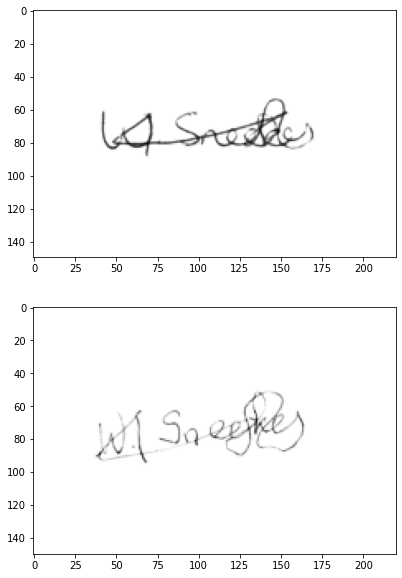

In [11]:
# Shows pre-processed samples of the two users

f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(preprocessed_img1)
ax[1].imshow(preprocessed_img2)

In [12]:
class SignatureDataset(Dataset):
    
    def __init__(self, df=train, canvas_size=canvas_size, dim=(256, 256)):
        self.df  = df
        self.real_file_names = df["image_real_paths"].values
        self.forged_file_names = df["image_forged_paths"].values
        self.labels = df["label"].values
        self.dim = dim

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,index):
        # getting the image path
        real_file_path = self.real_file_names[index]
        forged_file_path = self.forged_file_names[index]
        
        img1 = load_signature(real_file_path)
        img2 = load_signature(forged_file_path)
        
        img1 = preprocess_signature(img1, canvas_size, self.dim)
        img2 = preprocess_signature(img2, canvas_size, self.dim)
        
        label = torch.tensor(self.labels[index], dtype=torch.long)
        
        return torch.tensor(img1), torch.tensor(img2), label

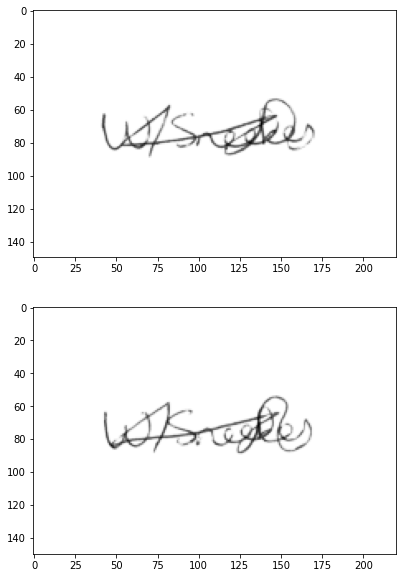

In [13]:
train_dataset = SignatureDataset(train, canvas_size, img_size)
img1, img2, _ = train_dataset[120]

f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(img1)
ax[1].imshow(img2)

In [14]:
class SigNet(nn.Module):
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self):
        super(SigNet, self).__init__()

        self.feature_space_size = 2048

        self.conv_layers = nn.Sequential(OrderedDict([
            ('conv1', conv_bn_mish(1, 96, 11, stride=4)),
            ('maxpool1', nn.MaxPool2d(3, 2)),
            ('conv2', conv_bn_mish(96, 256, 5, pad=2)),
            ('maxpool2', nn.MaxPool2d(3, 2)),
            ('conv3', conv_bn_mish(256, 384, 3, pad=1)),
            ('conv4', conv_bn_mish(384, 384, 3, pad=1)),
            ('conv5', conv_bn_mish(384, 256, 3, pad=1)),
            ('maxpool3', nn.MaxPool2d(3, 2)),
        ]))

        self.fc_layers = nn.Sequential(OrderedDict([
            ('fc1', linear_bn_mish(256 * 3 * 5, 2048)),
            ('fc2', linear_bn_mish(self.feature_space_size, self.feature_space_size)),
        ]))
    
    def forward_once(self, img):
        x = self.conv_layers(img)
        x = x.view(x.shape[0], 256 * 3 * 5)
        x = self.fc_layers(x)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        # forward pass of input 1
        output1 = self.forward_once(img1)
        # forward pass of input 2
        output2 = self.forward_once(img2)
        return output1, output2


def conv_bn_mish(in_channels, out_channels, kernel_size,  stride=1, pad=0):
    return nn.Sequential(OrderedDict([
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False)),
        ('bn', nn.BatchNorm2d(out_channels)),
        ('relu', nn.Mish()),
    ]))


def linear_bn_mish(in_features, out_features):
    return nn.Sequential(OrderedDict([
        ('fc', nn.Linear(in_features, out_features, bias=False)),  # Bias is added after BN
        ('bn', nn.BatchNorm1d(out_features)),
        ('relu', nn.Mish()),
    ]))

In [15]:
#model = SigNet()
#model.eval()
#x1, x2 = model(img1, img2)

In [16]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.cosine_similarity(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [17]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, layer):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    tk0 = tqdm(train_loader, total=len(train_loader))
    for step, (img1, img2, labels) in enumerate(tk0):
        # measure data loading time
        data_time.update(time.time() - end)
        img1 = img1.to(device).float()
        img2 = img2.to(device).float()
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                out1, out2 = model(img1, img2)
                layer1 = layer(out1)
                layer2 = layer(out2)
                loss = criterion(layer1, layer2, labels)
        else:
            out1, out2 = model(img1, img2)
            loss = criterion(out1, out2, labels)
            
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f} '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_last_lr()[0]))
        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_last_lr()[0]})
    return losses.avg

In [18]:
# ====================================================
# Train loop
# ====================================================
def train_loop():
    

    # ====================================================
    # loader
    # ====================================================
    
    train_dataset = SignatureDataset(train, CFG.canvas_size, dim=(256, 256))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
   
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.reduce_params)
        elif CFG.scheduler=='OneCycleLR':
            scheduler = OneCycleLR(optimizer, **CFG.onecycle_params)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = SigNet()
    state_dict, _, _ = torch.load("../input/pretrained-signature-weights/signet.pth")
    model.load_state_dict(state_dict)
    model.to(device)
    

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterions = ContrastiveLoss()
    contrastive_layer = nn.Linear(2048, 2)
    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train, train_loader, model, criterions, optimizer, epoch, scheduler, device, contrastive_layer)

        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, OneCycleLR):
            scheduler.step()


        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s')
        wandb.log({f"epoch": epoch+1, 
                   f"avg_train_loss": avg_loss})
                 
            
        if avg_loss < best_loss:
            best_loss = avg_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict()}, 
                        OUTPUT_DIR+f'{CFG.model_name}_best_loss.pt')
   
   
    wandb.finish()    
    return model

In [19]:
model = train_loop()

  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [1][0/2900] Elapsed 0m 9s (remain 473m 42s) Loss: 0.3113(0.3113) Grad: 3.6584 LR: 0.000010  
Epoch: [1][100/2900] Elapsed 1m 8s (remain 31m 50s) Loss: 0.2866(0.3533) Grad: 3.6201 LR: 0.000010  
Epoch: [1][200/2900] Elapsed 2m 8s (remain 28m 48s) Loss: 0.2171(0.3311) Grad: 3.6441 LR: 0.000010  
Epoch: [1][300/2900] Elapsed 3m 7s (remain 27m 0s) Loss: 0.2455(0.3166) Grad: 3.7035 LR: 0.000010  
Epoch: [1][400/2900] Elapsed 4m 6s (remain 25m 37s) Loss: 0.2451(0.3058) Grad: 3.4428 LR: 0.000010  
Epoch: [1][500/2900] Elapsed 5m 6s (remain 24m 26s) Loss: 0.2111(0.2973) Grad: 4.3759 LR: 0.000010  
Epoch: [1][600/2900] Elapsed 6m 5s (remain 23m 18s) Loss: 0.2547(0.2890) Grad: 5.1913 LR: 0.000010  
Epoch: [1][700/2900] Elapsed 7m 4s (remain 22m 11s) Loss: 0.2726(0.2817) Grad: 5.2070 LR: 0.000010  
Epoch: [1][800/2900] Elapsed 8m 2s (remain 21m 5s) Loss: 0.2369(0.2753) Grad: 4.4285 LR: 0.000010  
Epoch: [1][900/2900] Elapsed 9m 0s (remain 20m 0s) Loss: 0.2547(0.2694) Grad: 5.2822 LR: 0.000

Epoch 1 - avg_train_loss: 0.1971  time: 1703s
Epoch 1 - Save Best Loss: 0.1971 Model


Epoch: [1][2899/2900] Elapsed 28m 22s (remain 0m 0s) Loss: 0.0983(0.1971) Grad: 4.4808 LR: 0.000010  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [2][0/2900] Elapsed 0m 2s (remain 134m 13s) Loss: 0.1153(0.1153) Grad: 3.0602 LR: 0.000162  
Epoch: [2][100/2900] Elapsed 1m 4s (remain 29m 33s) Loss: 0.4194(0.2548) Grad: 4.8947 LR: 0.000162  
Epoch: [2][200/2900] Elapsed 2m 3s (remain 27m 39s) Loss: 0.3533(0.2680) Grad: 3.2032 LR: 0.000162  
Epoch: [2][300/2900] Elapsed 3m 1s (remain 26m 8s) Loss: 0.1868(0.2640) Grad: 2.2563 LR: 0.000162  
Epoch: [2][400/2900] Elapsed 3m 59s (remain 24m 55s) Loss: 0.1099(0.2556) Grad: 1.8877 LR: 0.000162  
Epoch: [2][500/2900] Elapsed 4m 57s (remain 23m 45s) Loss: 0.2858(0.2483) Grad: 2.5815 LR: 0.000162  
Epoch: [2][600/2900] Elapsed 5m 56s (remain 22m 44s) Loss: 0.0928(0.2359) Grad: 1.7116 LR: 0.000162  
Epoch: [2][700/2900] Elapsed 6m 55s (remain 21m 43s) Loss: 0.0640(0.2268) Grad: 1.0506 LR: 0.000162  
Epoch: [2][800/2900] Elapsed 7m 54s (remain 20m 43s) Loss: 0.1196(0.2221) Grad: 3.7517 LR: 0.000162  
Epoch: [2][900/2900] Elapsed 8m 51s (remain 19m 40s) Loss: 0.3186(0.2159) Grad: 4.7604 L

Epoch 2 - avg_train_loss: 0.1574  time: 1694s
Epoch 2 - Save Best Loss: 0.1574 Model


Epoch: [2][2899/2900] Elapsed 28m 13s (remain 0m 0s) Loss: 0.0662(0.1574) Grad: 3.7834 LR: 0.000162  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [3][0/2900] Elapsed 0m 2s (remain 139m 27s) Loss: 0.0219(0.0219) Grad: 0.8638 LR: 0.000525  
Epoch: [3][100/2900] Elapsed 1m 2s (remain 28m 52s) Loss: 0.3556(0.2602) Grad: 2.8488 LR: 0.000525  
Epoch: [3][200/2900] Elapsed 1m 59s (remain 26m 51s) Loss: 0.2691(0.2781) Grad: 3.1570 LR: 0.000525  
Epoch: [3][300/2900] Elapsed 2m 58s (remain 25m 38s) Loss: 0.2373(0.2722) Grad: 2.1161 LR: 0.000525  
Epoch: [3][400/2900] Elapsed 3m 56s (remain 24m 35s) Loss: 0.5501(0.2628) Grad: 5.9975 LR: 0.000525  
Epoch: [3][500/2900] Elapsed 4m 54s (remain 23m 29s) Loss: 0.1298(0.2480) Grad: 1.5903 LR: 0.000525  
Epoch: [3][600/2900] Elapsed 5m 51s (remain 22m 26s) Loss: 0.2053(0.2348) Grad: 2.2609 LR: 0.000525  
Epoch: [3][700/2900] Elapsed 6m 50s (remain 21m 27s) Loss: 0.1286(0.2309) Grad: 1.9841 LR: 0.000525  
Epoch: [3][800/2900] Elapsed 7m 48s (remain 20m 27s) Loss: 0.1089(0.2231) Grad: 0.8719 LR: 0.000525  
Epoch: [3][900/2900] Elapsed 8m 46s (remain 19m 27s) Loss: 0.1147(0.2138) Grad: 0.862

Epoch 3 - avg_train_loss: 0.1671  time: 1687s


Epoch: [3][2899/2900] Elapsed 28m 7s (remain 0m 0s) Loss: 0.0953(0.1671) Grad: 2.3833 LR: 0.000525  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [4][0/2900] Elapsed 0m 2s (remain 139m 36s) Loss: 0.3945(0.3945) Grad: 5.0400 LR: 0.000876  
Epoch: [4][100/2900] Elapsed 1m 2s (remain 28m 56s) Loss: 0.1914(0.1879) Grad: 1.4743 LR: 0.000876  
Epoch: [4][200/2900] Elapsed 2m 0s (remain 27m 0s) Loss: 0.1810(0.1728) Grad: 2.1722 LR: 0.000876  
Epoch: [4][300/2900] Elapsed 2m 59s (remain 25m 46s) Loss: 0.0901(0.1774) Grad: 1.0854 LR: 0.000876  
Epoch: [4][400/2900] Elapsed 3m 56s (remain 24m 33s) Loss: 0.2194(0.1824) Grad: 2.1142 LR: 0.000876  
Epoch: [4][500/2900] Elapsed 4m 54s (remain 23m 31s) Loss: 0.0620(0.1794) Grad: 0.6992 LR: 0.000876  
Epoch: [4][600/2900] Elapsed 5m 53s (remain 22m 31s) Loss: 0.1209(0.1745) Grad: 2.1078 LR: 0.000876  
Epoch: [4][700/2900] Elapsed 6m 51s (remain 21m 32s) Loss: 0.4239(0.1730) Grad: 4.7005 LR: 0.000876  
Epoch: [4][800/2900] Elapsed 7m 49s (remain 20m 30s) Loss: 0.0797(0.1687) Grad: 2.1308 LR: 0.000876  
Epoch: [4][900/2900] Elapsed 8m 47s (remain 19m 31s) Loss: 0.0953(0.1680) Grad: 1.7190 

Epoch 4 - avg_train_loss: 0.1403  time: 1691s
Epoch 4 - Save Best Loss: 0.1403 Model


Epoch: [4][2899/2900] Elapsed 28m 11s (remain 0m 0s) Loss: 0.0787(0.1403) Grad: 2.2199 LR: 0.000876  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [5][0/2900] Elapsed 0m 3s (remain 147m 45s) Loss: 0.0981(0.0981) Grad: 2.2069 LR: 0.001000  
Epoch: [5][100/2900] Elapsed 1m 4s (remain 29m 37s) Loss: 0.0954(0.1272) Grad: 0.8410 LR: 0.001000  
Epoch: [5][200/2900] Elapsed 2m 1s (remain 27m 8s) Loss: 0.0605(0.1392) Grad: 1.5256 LR: 0.001000  
Epoch: [5][300/2900] Elapsed 2m 59s (remain 25m 54s) Loss: 0.0668(0.1244) Grad: 1.3605 LR: 0.001000  
Epoch: [5][400/2900] Elapsed 3m 57s (remain 24m 40s) Loss: 0.0868(0.1271) Grad: 0.8801 LR: 0.001000  
Epoch: [5][500/2900] Elapsed 4m 54s (remain 23m 31s) Loss: 0.1020(0.1223) Grad: 1.9963 LR: 0.001000  
Epoch: [5][600/2900] Elapsed 5m 52s (remain 22m 28s) Loss: 0.0173(0.1147) Grad: 0.2623 LR: 0.001000  
Epoch: [5][700/2900] Elapsed 6m 50s (remain 21m 27s) Loss: 0.1423(0.1142) Grad: 1.5368 LR: 0.001000  
Epoch: [5][800/2900] Elapsed 7m 46s (remain 20m 23s) Loss: 0.0586(0.1134) Grad: 1.0218 LR: 0.001000  
Epoch: [5][900/2900] Elapsed 8m 45s (remain 19m 26s) Loss: 0.0755(0.1125) Grad: 1.2250 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0b11345ef0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch: [5][2800/2900] Elapsed 27m 9s (remain 0m 57s) Loss: 0.0170(0.1069) Grad: 0.3728 LR: 0.001000  


Epoch 5 - avg_train_loss: 0.1061  time: 1686s
Epoch 5 - Save Best Loss: 0.1061 Model


Epoch: [5][2899/2900] Elapsed 28m 6s (remain 0m 0s) Loss: 0.1241(0.1061) Grad: 1.5823 LR: 0.001000  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [6][0/2900] Elapsed 0m 2s (remain 132m 28s) Loss: 0.1821(0.1821) Grad: 4.0580 LR: 0.000998  
Epoch: [6][100/2900] Elapsed 1m 3s (remain 29m 11s) Loss: 0.1684(0.1128) Grad: 1.6993 LR: 0.000998  
Epoch: [6][200/2900] Elapsed 2m 1s (remain 27m 17s) Loss: 0.1194(0.1017) Grad: 1.4549 LR: 0.000998  
Epoch: [6][300/2900] Elapsed 3m 0s (remain 25m 57s) Loss: 0.1461(0.1005) Grad: 1.7399 LR: 0.000998  
Epoch: [6][400/2900] Elapsed 3m 59s (remain 24m 50s) Loss: 0.1315(0.0989) Grad: 1.5227 LR: 0.000998  
Epoch: [6][500/2900] Elapsed 4m 57s (remain 23m 46s) Loss: 0.0378(0.1021) Grad: 1.0935 LR: 0.000998  
Epoch: [6][600/2900] Elapsed 5m 56s (remain 22m 45s) Loss: 0.0297(0.1010) Grad: 0.5239 LR: 0.000998  
Epoch: [6][700/2900] Elapsed 6m 55s (remain 21m 43s) Loss: 0.0506(0.0969) Grad: 0.7806 LR: 0.000998  


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0b11345ef0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0b11345ef0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Epoch: [6][800/2900] Elapsed 7m 54s (remain 20m 42s) Loss: 0.0085(0.0925) Grad: 0.1690 LR: 0.000998  
Epoch: [6][900/2900] Elapsed 8m 53s (remain 19m 42s) Loss: 0.8583(0.0934) Grad: 3.2795 LR: 0.000998  
Epoch: [6][1000/2900] Elapsed 9m 50s (remain 18m 41s) Loss: 0.0925(0.0907) Grad: 1.0170 LR: 0.000998  


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0b11345ef0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0b11345ef0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Epoch: [6][1100/2900] Elapsed 10m 49s (remain 17m 40s) Loss: 0.2890(0.0890) Grad: 2.4844 LR: 0.000998  
Epoch: [6][1200/2900] Elapsed 11m 47s (remain 16m 40s) Loss: 0.1578(0.0879) Grad: 1.9319 LR: 0.000998  
Epoch: [6][1300/2900] Elapsed 12m 46s (remain 15m 41s) Loss: 0.0229(0.0859) Grad: 0.5440 LR: 0.000998  
Epoch: [6][1400/2900] Elapsed 13m 44s (remain 14m 42s) Loss: 0.0497(0.0880) Grad: 1.0880 LR: 0.000998  
Epoch: [6][1500/2900] Elapsed 14m 43s (remain 13m 43s) Loss: 0.0354(0.0886) Grad: 0.6979 LR: 0.000998  
Epoch: [6][1600/2900] Elapsed 15m 42s (remain 12m 44s) Loss: 0.0163(0.0885) Grad: 0.2395 LR: 0.000998  
Epoch: [6][1700/2900] Elapsed 16m 40s (remain 11m 45s) Loss: 0.0215(0.0863) Grad: 0.3099 LR: 0.000998  
Epoch: [6][1800/2900] Elapsed 17m 38s (remain 10m 45s) Loss: 0.0494(0.0853) Grad: 0.7973 LR: 0.000998  
Epoch: [6][1900/2900] Elapsed 18m 37s (remain 9m 47s) Loss: 0.1737(0.0835) Grad: 2.0435 LR: 0.000998  
Epoch: [6][2000/2900] Elapsed 19m 35s (remain 8m 48s) Loss: 0.034

Epoch 6 - avg_train_loss: 0.0824  time: 1702s
Epoch 6 - Save Best Loss: 0.0824 Model


Epoch: [6][2899/2900] Elapsed 28m 22s (remain 0m 0s) Loss: 0.0697(0.0824) Grad: 1.3746 LR: 0.000998  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [7][0/2900] Elapsed 0m 11s (remain 555m 36s) Loss: 0.0881(0.0881) Grad: 1.4764 LR: 0.000994  
Epoch: [7][100/2900] Elapsed 1m 12s (remain 33m 36s) Loss: 0.0305(0.0745) Grad: 0.5017 LR: 0.000994  
Epoch: [7][200/2900] Elapsed 2m 12s (remain 29m 33s) Loss: 0.2140(0.0616) Grad: 3.5840 LR: 0.000994  
Epoch: [7][300/2900] Elapsed 3m 12s (remain 27m 40s) Loss: 0.0644(0.0623) Grad: 0.8257 LR: 0.000994  
Epoch: [7][400/2900] Elapsed 4m 12s (remain 26m 11s) Loss: 0.1878(0.0640) Grad: 2.6968 LR: 0.000994  
Epoch: [7][500/2900] Elapsed 5m 10s (remain 24m 49s) Loss: 0.0144(0.0705) Grad: 0.4609 LR: 0.000994  
Epoch: [7][600/2900] Elapsed 6m 11s (remain 23m 41s) Loss: 0.2511(0.0675) Grad: 5.9686 LR: 0.000994  
Epoch: [7][700/2900] Elapsed 7m 11s (remain 22m 33s) Loss: 0.0285(0.0688) Grad: 0.5813 LR: 0.000994  
Epoch: [7][800/2900] Elapsed 8m 11s (remain 21m 27s) Loss: 0.0579(0.0683) Grad: 2.1644 LR: 0.000994  
Epoch: [7][900/2900] Elapsed 9m 10s (remain 20m 22s) Loss: 0.0224(0.0717) Grad: 0.3

Epoch 7 - avg_train_loss: 0.0668  time: 1736s
Epoch 7 - Save Best Loss: 0.0668 Model


Epoch: [7][2899/2900] Elapsed 28m 55s (remain 0m 0s) Loss: 0.2459(0.0668) Grad: 2.2029 LR: 0.000994  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [8][0/2900] Elapsed 0m 3s (remain 147m 4s) Loss: 0.0125(0.0125) Grad: 0.2934 LR: 0.000988  
Epoch: [8][100/2900] Elapsed 1m 3s (remain 29m 28s) Loss: 0.0169(0.0635) Grad: 0.5567 LR: 0.000988  
Epoch: [8][200/2900] Elapsed 2m 2s (remain 27m 22s) Loss: 0.0121(0.0478) Grad: 0.4007 LR: 0.000988  
Epoch: [8][300/2900] Elapsed 3m 1s (remain 26m 5s) Loss: 0.0539(0.0547) Grad: 0.7401 LR: 0.000988  
Epoch: [8][400/2900] Elapsed 4m 1s (remain 25m 1s) Loss: 0.0248(0.0575) Grad: 0.3810 LR: 0.000988  
Epoch: [8][500/2900] Elapsed 5m 0s (remain 23m 57s) Loss: 0.0266(0.0620) Grad: 0.8141 LR: 0.000988  
Epoch: [8][600/2900] Elapsed 5m 59s (remain 22m 54s) Loss: 0.0429(0.0687) Grad: 0.7214 LR: 0.000988  
Epoch: [8][700/2900] Elapsed 6m 58s (remain 21m 53s) Loss: 0.0299(0.0715) Grad: 0.5039 LR: 0.000988  
Epoch: [8][800/2900] Elapsed 7m 58s (remain 20m 53s) Loss: 0.0463(0.0710) Grad: 0.8806 LR: 0.000988  
Epoch: [8][900/2900] Elapsed 8m 58s (remain 19m 55s) Loss: 0.0205(0.0686) Grad: 0.4307 LR: 0

Epoch 8 - avg_train_loss: 0.0619  time: 1719s
Epoch 8 - Save Best Loss: 0.0619 Model


Epoch: [8][2899/2900] Elapsed 28m 38s (remain 0m 0s) Loss: 0.0549(0.0619) Grad: 2.1838 LR: 0.000988  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [9][0/2900] Elapsed 0m 2s (remain 138m 7s) Loss: 0.0236(0.0236) Grad: 0.3996 LR: 0.000979  
Epoch: [9][100/2900] Elapsed 1m 4s (remain 29m 47s) Loss: 0.1099(0.0445) Grad: 3.8427 LR: 0.000979  
Epoch: [9][200/2900] Elapsed 2m 4s (remain 27m 52s) Loss: 0.0404(0.0592) Grad: 1.7093 LR: 0.000979  
Epoch: [9][300/2900] Elapsed 3m 4s (remain 26m 31s) Loss: 0.0595(0.0573) Grad: 1.4609 LR: 0.000979  
Epoch: [9][400/2900] Elapsed 4m 2s (remain 25m 11s) Loss: 0.0113(0.0576) Grad: 0.4925 LR: 0.000979  
Epoch: [9][500/2900] Elapsed 5m 2s (remain 24m 7s) Loss: 0.0158(0.0621) Grad: 0.6288 LR: 0.000979  
Epoch: [9][600/2900] Elapsed 6m 1s (remain 23m 4s) Loss: 0.0162(0.0646) Grad: 0.4839 LR: 0.000979  
Epoch: [9][700/2900] Elapsed 7m 0s (remain 21m 59s) Loss: 0.0797(0.0627) Grad: 1.6001 LR: 0.000979  
Epoch: [9][800/2900] Elapsed 8m 0s (remain 20m 59s) Loss: 0.0883(0.0613) Grad: 2.0879 LR: 0.000979  
Epoch: [9][900/2900] Elapsed 8m 58s (remain 19m 53s) Loss: 0.0908(0.0602) Grad: 8.1922 LR: 0.00

Epoch 9 - avg_train_loss: 0.0561  time: 1717s
Epoch 9 - Save Best Loss: 0.0561 Model


Epoch: [9][2899/2900] Elapsed 28m 37s (remain 0m 0s) Loss: 0.1567(0.0561) Grad: 2.0538 LR: 0.000979  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [10][0/2900] Elapsed 0m 2s (remain 140m 1s) Loss: 0.0897(0.0897) Grad: 1.9742 LR: 0.000967  
Epoch: [10][100/2900] Elapsed 1m 3s (remain 29m 32s) Loss: 0.0700(0.0385) Grad: 1.1467 LR: 0.000967  
Epoch: [10][200/2900] Elapsed 2m 2s (remain 27m 19s) Loss: 0.0179(0.0377) Grad: 0.4979 LR: 0.000967  
Epoch: [10][300/2900] Elapsed 3m 0s (remain 25m 56s) Loss: 0.0117(0.0411) Grad: 0.3194 LR: 0.000967  
Epoch: [10][400/2900] Elapsed 3m 58s (remain 24m 44s) Loss: 0.0149(0.0421) Grad: 0.3380 LR: 0.000967  
Epoch: [10][500/2900] Elapsed 4m 56s (remain 23m 38s) Loss: 0.0085(0.0424) Grad: 0.6769 LR: 0.000967  
Epoch: [10][600/2900] Elapsed 5m 54s (remain 22m 35s) Loss: 0.0702(0.0432) Grad: 1.0092 LR: 0.000967  
Epoch: [10][700/2900] Elapsed 6m 53s (remain 21m 36s) Loss: 0.0136(0.0422) Grad: 0.3749 LR: 0.000967  
Epoch: [10][800/2900] Elapsed 7m 51s (remain 20m 36s) Loss: 0.0310(0.0438) Grad: 1.0294 LR: 0.000967  
Epoch: [10][900/2900] Elapsed 8m 51s (remain 19m 38s) Loss: 0.0594(0.0477) Grad

Epoch 10 - avg_train_loss: 0.0541  time: 1707s
Epoch 10 - Save Best Loss: 0.0541 Model


Epoch: [10][2899/2900] Elapsed 28m 26s (remain 0m 0s) Loss: 0.0065(0.0541) Grad: 0.1609 LR: 0.000967  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [11][0/2900] Elapsed 0m 2s (remain 140m 5s) Loss: 0.0173(0.0173) Grad: 0.4605 LR: 0.000954  
Epoch: [11][100/2900] Elapsed 1m 4s (remain 29m 56s) Loss: 0.0111(0.0447) Grad: 0.2445 LR: 0.000954  
Epoch: [11][200/2900] Elapsed 2m 5s (remain 28m 11s) Loss: 0.0119(0.0386) Grad: 0.2909 LR: 0.000954  
Epoch: [11][300/2900] Elapsed 3m 4s (remain 26m 35s) Loss: 0.0331(0.0434) Grad: 1.0367 LR: 0.000954  
Epoch: [11][400/2900] Elapsed 4m 3s (remain 25m 15s) Loss: 0.0216(0.0428) Grad: 1.1507 LR: 0.000954  
Epoch: [11][500/2900] Elapsed 5m 1s (remain 24m 5s) Loss: 0.0362(0.0408) Grad: 2.0956 LR: 0.000954  
Epoch: [11][600/2900] Elapsed 6m 0s (remain 22m 59s) Loss: 0.0213(0.0394) Grad: 0.3207 LR: 0.000954  
Epoch: [11][700/2900] Elapsed 7m 0s (remain 21m 57s) Loss: 0.0024(0.0407) Grad: 0.0925 LR: 0.000954  
Epoch: [11][800/2900] Elapsed 7m 58s (remain 20m 54s) Loss: 0.0060(0.0408) Grad: 0.1592 LR: 0.000954  
Epoch: [11][900/2900] Elapsed 8m 56s (remain 19m 50s) Loss: 0.0629(0.0395) Grad: 3.0

Epoch 11 - avg_train_loss: 0.0547  time: 1714s


Epoch: [11][2899/2900] Elapsed 28m 33s (remain 0m 0s) Loss: 0.0109(0.0547) Grad: 0.4219 LR: 0.000954  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [12][0/2900] Elapsed 0m 3s (remain 146m 31s) Loss: 0.0095(0.0095) Grad: 0.4357 LR: 0.000937  
Epoch: [12][100/2900] Elapsed 1m 4s (remain 29m 59s) Loss: 0.0853(0.0596) Grad: 1.9119 LR: 0.000937  
Epoch: [12][200/2900] Elapsed 2m 6s (remain 28m 12s) Loss: 0.0196(0.0504) Grad: 0.5567 LR: 0.000937  
Epoch: [12][300/2900] Elapsed 3m 5s (remain 26m 43s) Loss: 0.0312(0.0502) Grad: 0.9994 LR: 0.000937  
Epoch: [12][400/2900] Elapsed 4m 4s (remain 25m 24s) Loss: 0.0231(0.0568) Grad: 0.7153 LR: 0.000937  
Epoch: [12][500/2900] Elapsed 5m 4s (remain 24m 15s) Loss: 0.0203(0.0547) Grad: 0.6749 LR: 0.000937  
Epoch: [12][600/2900] Elapsed 6m 2s (remain 23m 6s) Loss: 0.0488(0.0525) Grad: 1.4942 LR: 0.000937  
Epoch: [12][700/2900] Elapsed 7m 1s (remain 22m 2s) Loss: 0.0431(0.0506) Grad: 0.7238 LR: 0.000937  
Epoch: [12][800/2900] Elapsed 8m 1s (remain 21m 2s) Loss: 0.0203(0.0487) Grad: 0.7003 LR: 0.000937  


wandb: Network error (ReadTimeout), entering retry loop.


Epoch: [12][900/2900] Elapsed 9m 0s (remain 19m 59s) Loss: 0.0204(0.0485) Grad: 0.3691 LR: 0.000937  
Epoch: [12][1000/2900] Elapsed 10m 0s (remain 18m 58s) Loss: 0.0595(0.0492) Grad: 1.1671 LR: 0.000937  
Epoch: [12][1100/2900] Elapsed 10m 59s (remain 17m 58s) Loss: 0.0055(0.0473) Grad: 0.3093 LR: 0.000937  
Epoch: [12][1200/2900] Elapsed 12m 0s (remain 16m 59s) Loss: 0.0396(0.0463) Grad: 1.8471 LR: 0.000937  
Epoch: [12][1300/2900] Elapsed 13m 1s (remain 16m 0s) Loss: 0.1808(0.0450) Grad: 2.2589 LR: 0.000937  
Epoch: [12][1400/2900] Elapsed 14m 2s (remain 15m 0s) Loss: 0.0085(0.0447) Grad: 0.3503 LR: 0.000937  
Epoch: [12][1500/2900] Elapsed 15m 1s (remain 14m 0s) Loss: 0.0029(0.0432) Grad: 0.0994 LR: 0.000937  
Epoch: [12][1600/2900] Elapsed 16m 3s (remain 13m 1s) Loss: 0.0091(0.0419) Grad: 0.3259 LR: 0.000937  
Epoch: [12][1700/2900] Elapsed 17m 3s (remain 12m 1s) Loss: 0.0474(0.0426) Grad: 4.0936 LR: 0.000937  
Epoch: [12][1800/2900] Elapsed 18m 3s (remain 11m 1s) Loss: 0.0229(0.0

Epoch 12 - avg_train_loss: 0.0480  time: 1749s
Epoch 12 - Save Best Loss: 0.0480 Model


Epoch: [12][2899/2900] Elapsed 29m 9s (remain 0m 0s) Loss: 0.0072(0.0480) Grad: 0.1730 LR: 0.000937  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [13][0/2900] Elapsed 0m 2s (remain 129m 57s) Loss: 0.0208(0.0208) Grad: 0.8353 LR: 0.000919  
Epoch: [13][100/2900] Elapsed 1m 4s (remain 29m 57s) Loss: 0.0031(0.0587) Grad: 0.1145 LR: 0.000919  
Epoch: [13][200/2900] Elapsed 2m 5s (remain 28m 3s) Loss: 0.0040(0.0427) Grad: 0.1849 LR: 0.000919  
Epoch: [13][300/2900] Elapsed 3m 4s (remain 26m 36s) Loss: 0.0226(0.0356) Grad: 0.4367 LR: 0.000919  
Epoch: [13][400/2900] Elapsed 4m 5s (remain 25m 31s) Loss: 0.0260(0.0321) Grad: 1.7599 LR: 0.000919  
Epoch: [13][500/2900] Elapsed 5m 6s (remain 24m 26s) Loss: 0.0073(0.0328) Grad: 0.1884 LR: 0.000919  
Epoch: [13][600/2900] Elapsed 6m 6s (remain 23m 23s) Loss: 0.0114(0.0324) Grad: 1.1863 LR: 0.000919  
Epoch: [13][700/2900] Elapsed 7m 7s (remain 22m 22s) Loss: 0.0119(0.0323) Grad: 0.4549 LR: 0.000919  
Epoch: [13][800/2900] Elapsed 8m 8s (remain 21m 20s) Loss: 0.0435(0.0423) Grad: 1.1502 LR: 0.000919  
Epoch: [13][900/2900] Elapsed 9m 8s (remain 20m 16s) Loss: 0.0295(0.0438) Grad: 1.07

Epoch 13 - avg_train_loss: 0.0439  time: 1757s
Epoch 13 - Save Best Loss: 0.0439 Model


Epoch: [13][2899/2900] Elapsed 29m 16s (remain 0m 0s) Loss: 0.0158(0.0439) Grad: 0.4799 LR: 0.000919  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [14][0/2900] Elapsed 0m 2s (remain 134m 21s) Loss: 0.0191(0.0191) Grad: 0.4852 LR: 0.000899  
Epoch: [14][100/2900] Elapsed 1m 5s (remain 30m 20s) Loss: 0.0056(0.0448) Grad: 0.1984 LR: 0.000899  
Epoch: [14][200/2900] Elapsed 2m 6s (remain 28m 20s) Loss: 0.0808(0.0510) Grad: 1.9764 LR: 0.000899  
Epoch: [14][300/2900] Elapsed 3m 7s (remain 27m 2s) Loss: 0.0480(0.0526) Grad: 2.0452 LR: 0.000899  
Epoch: [14][400/2900] Elapsed 4m 7s (remain 25m 42s) Loss: 0.0281(0.0508) Grad: 1.1385 LR: 0.000899  
Epoch: [14][500/2900] Elapsed 5m 8s (remain 24m 36s) Loss: 0.0628(0.0544) Grad: 1.0896 LR: 0.000899  
Epoch: [14][600/2900] Elapsed 6m 8s (remain 23m 31s) Loss: 0.0159(0.0564) Grad: 0.3777 LR: 0.000899  
Epoch: [14][700/2900] Elapsed 7m 9s (remain 22m 28s) Loss: 0.0187(0.0564) Grad: 0.3042 LR: 0.000899  
Epoch: [14][800/2900] Elapsed 8m 10s (remain 21m 26s) Loss: 0.0273(0.0527) Grad: 1.0007 LR: 0.000899  
Epoch: [14][900/2900] Elapsed 9m 10s (remain 20m 22s) Loss: 0.0087(0.0510) Grad: 0.

Epoch 14 - avg_train_loss: 0.0586  time: 1758s


Epoch: [14][2899/2900] Elapsed 29m 18s (remain 0m 0s) Loss: 0.0142(0.0586) Grad: 1.0688 LR: 0.000899  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [15][0/2900] Elapsed 0m 2s (remain 131m 21s) Loss: 0.0283(0.0283) Grad: 0.6431 LR: 0.000876  
Epoch: [15][100/2900] Elapsed 1m 6s (remain 30m 34s) Loss: 0.0078(0.0281) Grad: 0.1063 LR: 0.000876  
Epoch: [15][200/2900] Elapsed 2m 7s (remain 28m 36s) Loss: 0.0211(0.0304) Grad: 0.5078 LR: 0.000876  
Epoch: [15][300/2900] Elapsed 3m 8s (remain 27m 10s) Loss: 0.0294(0.0289) Grad: 1.5659 LR: 0.000876  
Epoch: [15][400/2900] Elapsed 4m 8s (remain 25m 48s) Loss: 0.0932(0.0310) Grad: 2.5516 LR: 0.000876  
Epoch: [15][500/2900] Elapsed 5m 8s (remain 24m 37s) Loss: 0.1116(0.0360) Grad: 2.9473 LR: 0.000876  
Epoch: [15][600/2900] Elapsed 6m 8s (remain 23m 29s) Loss: 0.0512(0.0406) Grad: 1.1404 LR: 0.000876  
Epoch: [15][700/2900] Elapsed 7m 8s (remain 22m 25s) Loss: 0.0113(0.0422) Grad: 0.2465 LR: 0.000876  
Epoch: [15][800/2900] Elapsed 8m 10s (remain 21m 24s) Loss: 0.0086(0.0417) Grad: 0.2339 LR: 0.000876  
Epoch: [15][900/2900] Elapsed 9m 12s (remain 20m 25s) Loss: 0.0438(0.0433) Grad: 2

Epoch 15 - avg_train_loss: 0.0383  time: 1765s
Epoch 15 - Save Best Loss: 0.0383 Model


Epoch: [15][2899/2900] Elapsed 29m 24s (remain 0m 0s) Loss: 0.0048(0.0383) Grad: 0.1959 LR: 0.000876  


[fold 068/09_068.png 068_forg/03_0113068.PNG label \ 0 068/09_068.png 068_forg/01_0124068.PNG 1 1 068/09_068.png 068_forg/02_0124068.PNG 1 2 068/09_068.png 068_forg/01_0113068.PNG 1 3 068/09_068.png 068_forg/04_0124068.PNG 1 4 068/09_068.png 068_forg/04_0113068.PNG 1 ... ... ... ... 23200 031/02_031.png 031/03_031.png 0 23201 031/02_031.png 031/12_031.png 0 23202 031/02_031.png 031/11_031.png 0 23203 031/02_031.png 031/06_031.png 0 23204 031/02_031.png 031/07_031.png 0 image_real_paths \ 0 ../input/signature-verification-dataset/sign_d... 1 ../input/signature-verification-dataset/sign_d... 2 ../input/signature-verification-dataset/sign_d... 3 ../input/signature-verification-dataset/sign_d... 4 ../input/signature-verification-dataset/sign_d... ... ... 23200 ../input/signature-verification-dataset/sign_d... 23201 ../input/signature-verification-dataset/sign_d... 23202 ../input/signature-verification-dataset/sign_d... 23203 ../input/signature-verification-dataset/sign_d... 23204 ../input/signature-verification-dataset/sign_d... image_forged_paths 0 ../input/signature-verification-dataset/sign_d... 1 ../input/signature-verification-dataset/sign_d... 2 ../input/signature-verification-dataset/sign_d... 3 ../input/signature-verification-dataset/sign_d... 4 ../input/signature-verification-dataset/sign_d... ... ... 23200 ../input/signature-verification-dataset/sign_d... 23201 ../input/signature-verification-dataset/sign_d... 23202 ../input/signature-verification-dataset/sign_d... 23203 ../input/signature-verification-dataset/sign_d... 23204 ../input/signature-verification-dataset/sign_d... [23205 rows x 5 columns]] loss,▄▃▃▄▃▄▃▂█▂▄▂▂▁▃▂▂▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▂▁▂▁▂▁
[fold 068/09_068.png 068_forg/03_0113068.PNG label \ 0 068/09_068.png 068_forg/01_0124068.PNG 1 1 068/09_068.png 068_forg/02_0124068.PNG 1 2 068/09_068.png 068_forg/01_0113068.PNG 1 3 068/09_068.png 068_forg/04_0124068.PNG 1 4 068/09_068.png 068_forg/04_0113068.PNG 1 ... ... ... ... 23200 031/02_031.png 031/03_031.png 0 23201 031/02_031.png 031/12_031.png 0 23202 031/02_031.png 031/11_031.png 0 23203 031/02_031.png 031/06_031.png 0 23204 031/02_031.png 031/07_031.png 0 image_real_paths \ 0 ../input/signature-verification-dataset/sign_d... 1 ../input/signature-verification-dataset/sign_d... 2 ../input/signature-verification-dataset/sign_d... 3 ../input/signature-verification-dataset/sign_d... 4 ../input/signature-verification-dataset/sign_d... ... ... 23200 ../input/signature-verification-dataset/sign_d... 23201 ../input/signature-verification-dataset/sign_d... 23202 ../input/signature-verification-dataset/sign_d... 23203 ../input/signature-verification-dataset/sign_d... 23204 ../input/signature-verification-dataset/sign_d... image_forged_paths 0 ../input/signature-verification-dataset/sign_d... 1 ../input/signature-verification-dataset/sign_d... 2 ../input/signature-verification-dataset/sign_d... 3 ../input/signature-verification-dataset/sign_d... 4 ../input/signature-verification-dataset/sign_d... ... ... 23200 ../input/signature-verification-dataset/sign_d... 23201 ../input/signature-verification-dataset/sign_d... 23202 ../input/signature-verification-dataset/sign_d... 23203 ../input/signature-verification-dataset/sign_d... 23204 ../input/signature-verification-dataset/sign_d... [23205 rows x 5 columns]] lr,▁▁▁▂▂▂▅▅▇▇▇█████████████████████▇▇▇▇▇▇▇▇
avg_train_loss,█▆▇▅▄▃▂▂▂▂▂▁▁▂▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
[fold 068/09_068.png 068_forg/03_0113068.PNG label \ 0 068/09_068.png 068_forg/01_0124068.PNG 1 1 068/09_068.png 068_forg/02_0124068.PNG 1 2 068/09_068.png 068_forg/01_0113068.PNG 1 3 068/09_068.png 068_forg/04_0124068.PNG 1 4 068/09_068.png 068_forg/04_0113068.PNG 1 ... ... ... ... 23200 031/02_031.png 031/03_031.png 0 23201 031/02_031.png 031/12_031.png 0 23202 031/02_031.png 031/11_031.png 0 23203 031/02_031.png 031/06_031.png 0 23204 031/02_031.png 031/07_031.png 0 image_real_paths \ 0 ../input/signature-verification-dataset/sign_d... 1 ../input/signature-verification-dataset/si

In [20]:
test_dataset = SignatureDataset(test, CFG.canvas_size, dim=(256, 256))
test_loader = DataLoader(test_dataset,
                          batch_size=1, 
                          shuffle=True)

In [21]:
model = SigNet()
state_dict = torch.load("./convnet_best_loss.pt")['model']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [22]:
#counter = 0 
#list_0 = torch.FloatTensor([[0]])
#list_1 = torch.FloatTensor([[1]])
#
#model.eval()
#for i, data in enumerate(test_loader, 0):
#    x0, x1, label = data
#    concatenated = torch.cat((x0, x1),0)
#    op1, op2 = model(x0, x1)
#    euc_dist = F.pairwise_distance(op1, op2)
#    if label==list_0:
#        label="Original"
#    else:
#        label="Forged"
#    f, ax = plt.subplots(1,2, figsize=(15,10))
#    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euc_dist.item():.2f} Label: {label}')
#    counter+=1
#    if counter==20:
#        break